## Stability - using barycentric interpolation

In [105]:
using CairoMakie

# Barycentric interpolation and background information

Given $N+1$ distinct nodes, $x_j$ for $j=1,...,N+1$, with numbers $f_j$ corresponding the value of $x_j$ for a given or unknown function $f$, a polynomial $p$ (of degree at most $N$) can be found such that $p$ interpolates $f$ at the points $x_j$ (i.e. $p(x_j)=f_j$) (Berrut , Trefethen 2004). This interpolation polynomial $p$ can be used to evaluate desired points for the function desired $f$.

The common way the solution can be written is in the *Lagrange form* (Berrut, Trefethen 2004): 

```math
p(x)= \sum_{j=1}^{N+1} f_j \ell_j(x), \qquad \ell_j(x)=\frac{\prod_{k=1, k \neq j}^{N+1} (x-x_k)}{\prod_{k=1, k \neq j}^{N+1}(x_j-x_k)},
```
where $\ell_j$ is the *Lagrange polynomial* corresponding to node $x_j$.

However, as discussed in (Berrut, Trefethen 2004), in this form each evaluation of $p(x)$ requires $O(N^2)$ additions and multiplications, and adding a new node and it's correspodnding $f$ value means starting from scratch all while the computation is numerically unstable. To combat this, Berrut and Trefethen rewrote $p(x)$ into a more useful form, known as the *barycentric formula* for $p$:

```math
p(x)=\frac{\sum_{j=1}^{N+1}\frac{w_j}{x-x_j}f_j}{\sum_{j=1}^{N+1} \frac{w_j}{x-x_j}}\tag{1},
```
where $w_j$ are the *barycentric weights*, defined as:

```math
w_j=\frac{1}{\prod_{k\neq j}(x_j-x_k)}, \quad j=1,...,N+1
```

This new form means the number of operations required to evaluate or add a new node decreases compared to the Lagrange form, making computation less expensive.

Equation (1) can be rearranged to give the barycentric representation of $\ell_j$ (Berrut, Trefethen 2004):
```math
\ell_j(x)=\frac{\frac{w_j}{(x-x_j)}}{\sum_{k=1}^{N+1} \frac{w_k}{x-x_k}}\tag{2}
```

Given $\ell_j$ in the form found in Equation (2) and some manipulation (Berrut et al 2004), the following can be obtained:

```math
\ell'_j(x_i)=\begin{cases} \ell'_j(x_i)=\frac{w_j/w_i}{x_i-x_j}, & \text{for $i\neq j$}\\
\ell'_j(x_j)=-\sum_{i\neq j} \ell'(x_j), & \text{for $i=j$}
\end{cases}
```
where $x_i$ are the interpolation points (with a different index). The first-order differentiation matrix $D^{(1)}$ is defined (Berrut et al 2004) as:
```math
D_{ij}^{(1)}=\ell_j'(x_i)
```

# The function ```j_eval```

The function ```j_eval``` utilises the theory above to find the values $f(x_e), f'(x_e), f''(x_e)$, etc. for desired point(s) $x_e$, having been given interpolation nodes $x_j$. 

The inputs for ```j_eval```:
1. `xj` are the interpolation points/nodes ($x_j$)
2. `xe` the points the user wants to evaluate at - the desired points ($x_e$)
3. Optional argument: `diff` is the derivative the user wants to find the desired points at (0=evaluation of $f$, 1=1st derivative, 2=2nd derivative)


The output for ```j_eval```:
1. `Dk` is matrix such that when multiplied by $\textbf{f}$ (the values of $f(x_j)$ in vector form), the user gets the values of $f(x_e)$ when `diff`=0; $f'(x_e)$ when `diff`=1, etc.


# The function `j_diff`

The function `j_diff` calculates the differentiation matrix $D^{(1)}$ for the interpolation points $x_j$. 
The function's input:
1. `xbase` are the interpolation points/nodes

The function's output:
1. `D1` is the 1st-order differentiation matrix for the interpolation points ($D^{(1)}_{ij}= \ell_j'(x_i)$ for an interpolation point x_i)

The function `j_diff` is used in `j_eval` when the user wants to find an $n$ th-order derivativeof $f$ at the desired points $x_e$

# Evaluating $f(x)$

When wishing to evaluate $f(x_e)$, the user must ensure the `diff` argument of `j_eval` is set to 0 (the default). For given interpolation points/nodes, $x_j$, and some desired points, $x_e$, the function ```j_eval``` uses Equation (2) to return the matrix 
```math
E_{ij}=\ell_j(x_i)
```
where $x_i$ is one of the points the user wishes to evaluate at, $x_e$. Let $\textbf{f}$ be the vector of the nodes corresponding numbers $f_j$ $(\textbf{f}=(f_1,f_2,...,f_{N+1})^T)$. Then
```math
f(x_e)=E^* \textbf{f}
```
returns the values of $f$ evaluated at the desired points $x_e$. 

# Differentiating $f(x)$

The function `j_eval` uses the matrix $D^{(1)}$ when the arugument `diff` is non-zero. When wishing to find $f'(x_e)$, the user must ensure the `diff` argument of `j_eval` is set to 1. If the user wishes to find $f''(x_e)$, the `diff` argument should be set to 2. For higher derivatives `diff` should be set at $n$ for the $n$ th-derivative.

For differentiation, the `j_eval` functions works like this:
1. `j_eval` finds the matrix $E$, 
2. Internally, `j_diff` is used to find $D^{(1)}$, which is named $D$ in `j_eval`  
3. The output matrix `Dk` is then found:
- If `diff`=1 then `Dk`=$E^*D$
- If `diff`=2 then `Dk`=$E^*D^*D$
- If `diff`=3 then `Dk`=$E^*D^*D^*D$

The output `Dk` of `j_eval` is then multiplied by the vector $\textbf{f}$, of $f_j$ values to find the derivative of $f$. 


The rest of this notebook goes through some examples. For ease, all the following examples in this notebook use a common set of interpolation points, $x_j$, called the Chebyshev points of the second kind, whose formula are:

```math
x_j=\cos \frac{j \pi}{n}, j=0,...,n

```
They have the explicit weight formula: 
```math
w_j=(-1)^j \delta_j,
\delta_j=
\begin{cases}
\frac{1}{2}, & \text{j=0 or j=n}\\
1, & \text{otherwise}
\end{cases}
```
While the given examples use Chebyshev points of the 2nd kind, the function ```j_eval``` can take any $x_j$ values the user provides and find their weights. Note that while the user can give any interpolation point $x_j$ into ```j_eval```, for large $N$ the user must ensure the points are clustered more heavily at the interval boundaries to ensure the interpolation is well-defined - Chebyshev points are an example of nodes that fit this criteria.

# Example 1

For the first example, we'll look at the function $f(x)=\cos(x)$, where we want the value of $\cos(0.5)$ and $\cos(0.75)$ - our $x_e$ are 0.5 and 0.75.

Below we demonstrate the use of function ```j_eval```:

In [106]:
include("../shared/j_diff.jl")
include("../shared/j_eval.jl")
N=20 #so we have 21 interpolation/Chebyshev points
xjvals=cos.(pi*(0:N)'/N)[:] #interpolation points in the form of chebyshev points of the 2nd kind
xivals=[0.5,0.75] #points you want to evaluate at (xe)
fvec=cos.(xjvals)[:] #fj values 

emat=j_eval(xjvals,xivals) #E matrix of lj(xi) components
fxivals2=(emat*fvec) #gives f(xe) values 

2-element Vector{Float64}:
 0.8775825618903723
 0.7316888688738209

In [107]:
#To check my function works we'll find the true value of f(xivals)
true_fxi=cos.([0.5,0.75])

2-element Vector{Float64}:
 0.8775825618903728
 0.7316888688738209

Next, we'll look at first-order differentiation: 

In [108]:
diffmat=j_eval(xjvals,xivals,diff=1) #utilises j_diff(xijvals) before outputting Dk=E*D
dfxivals=diffmat*fvec #gives f'(xe)=cos'([0.5,0.75])

2-element Vector{Float64}:
 -0.4794255386042049
 -0.6816387600233319

In [109]:
#Compare the above to the true values of f'(xe) -> cos'(x)=-sin(x)
diff_exact=-sin.(xivals)

2-element Vector{Float64}:
 -0.479425538604203
 -0.6816387600233341

Next we'll look at second-order differentiation:

In [110]:
#Finding f''(0.5), f''(0.75) for f(x)=cos(x)
D2=j_eval(xjvals,xivals,diff=2) #returns E*D*D
d2fvals=D2*fvec #gives f''(xe)

2-element Vector{Float64}:
 -0.8775825618900771
 -0.7316888688734228

In [111]:
#Compare to the true values: f''(x)=-cos(x)
true_d2fvals=-cos.(xivals)

2-element Vector{Float64}:
 -0.8775825618903728
 -0.7316888688738209

To find higher derivatives change the value of the `diff` argument in `j_eval`.

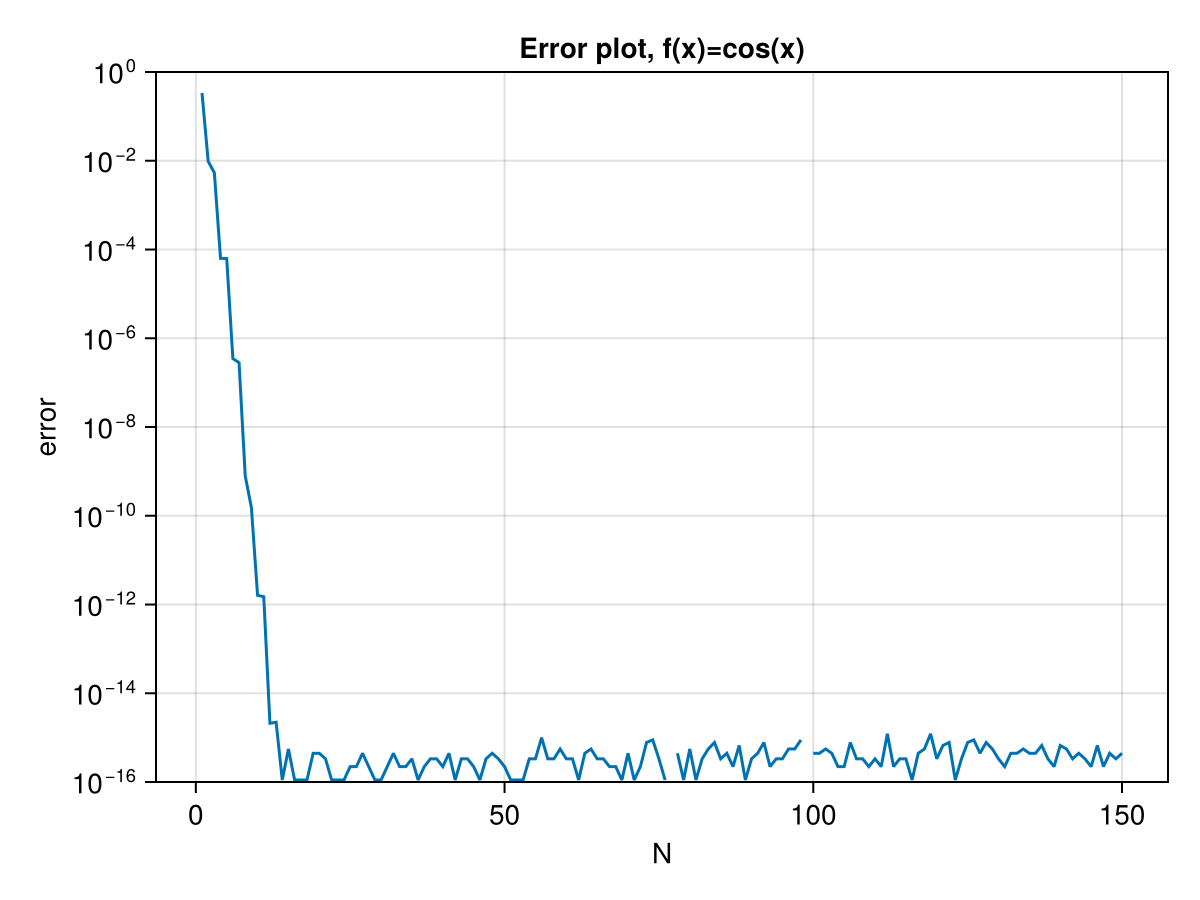

In [112]:
#Plot error for varying n
xivals=[0.5,0.75] #points you want to evaluate at
ni=[1:1:150;] #a sequence of increasing n from 1 to 150
max_error=fill(NaN, length(ni))
for k in 1:length(ni)
    xjvals_ni=cos.(pi*(0:ni[k])'/ni[k])[:] #interpolation points in the form of chebyshev points of the 2nd kind or n=ni[k]
    fvec_ni=cos.(xjvals_ni)[:]#fj values for xj values given n=ni[k]
    emat_ni=j_eval(xjvals_ni,xivals) #E matrix of lj(xi) components
    fxivals_ni=(emat_ni*fvec_ni)#finds estimated value of f(xi) using interpolation (polynomial)
    max_error[k]=findmax(abs.(fxivals_ni-true_fxi))[1] #finds maximum error between approximated f(xi) and the true f(xi)
end 
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="N",ylabel="error", title="Error plot, f(x)=cos(x)", yscale=log10) #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
lines!(ax1,ni,max_error)
ylims!(ax1,[1e-16,1])
fig1

The above plot shows the error decreasing drastically with increased number of interpolation points $N$. It is seen from this graph that around $N$=20 is sufficient to have small error. 

# Example 2

Next we'll look at another, more complicated example. The next example we'll look at is:
```math
f(x)=|x|+\frac{x}{2} -x^2
```

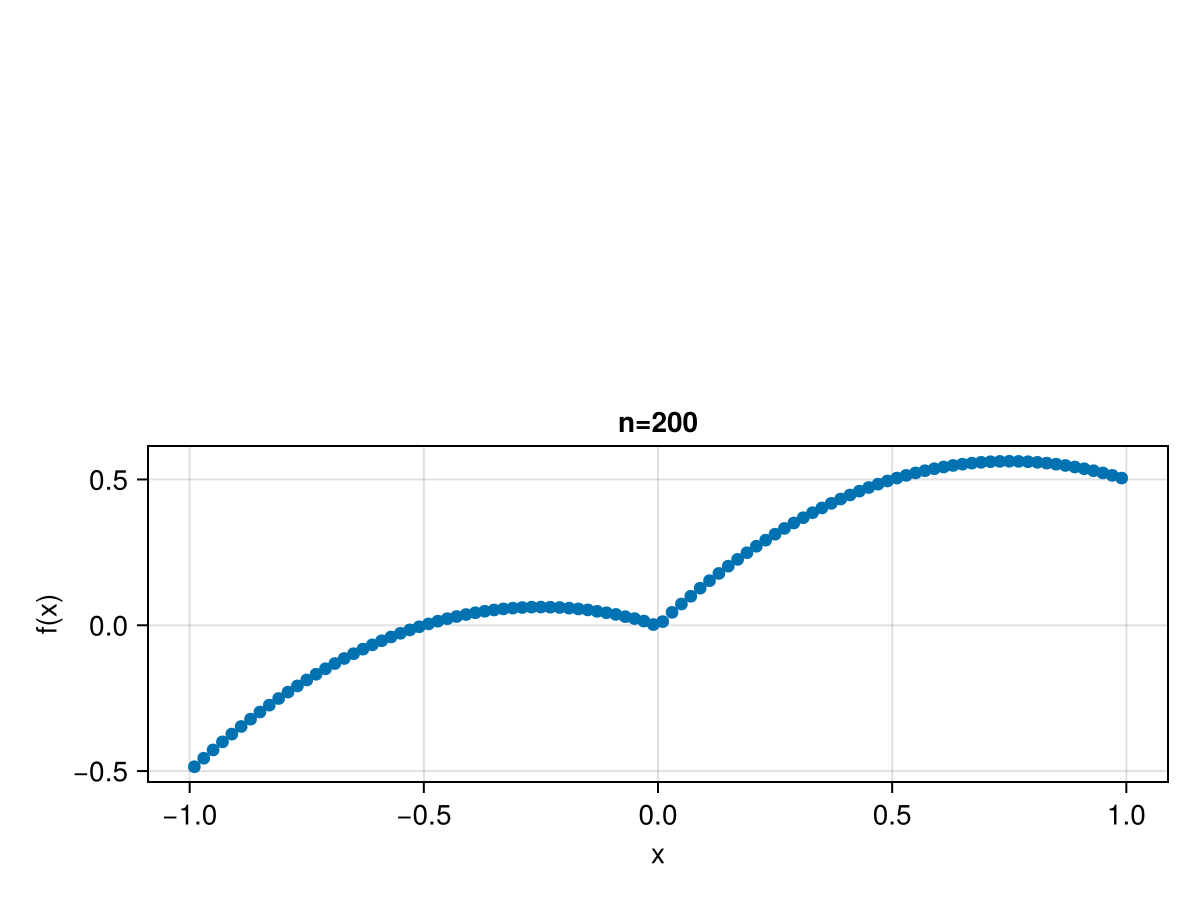

In [113]:
include("binter_example.jl")
n=200 #so we have 201 interpolation/Chebyshev points
xjvals=cos.(pi*(0:n)'/n)[:] 
xivals2=[-0.99:0.02:0.99;]
fvec2=binter_example(xjvals) #(xivals2)

emat2=j_eval(xjvals,xivals2) #E matrix of lj(xi) components
fxivals2=(emat2*fvec2)#./(emat4*vec1)

fig2=Figure()
ax2=Axis(fig2[2,1],xlabel="x",ylabel="f(x)",title="n=200") #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
scatter!(ax2,xivals2,fxivals2)
fig2

Note that this example is good to show that more commplicated functions can be explored using barycentric interpolation, however, differentiation is complicated here. The error plot below for increasing the number of interpolation points $N$ supports the complicated nature of $f(x)=|x|+0.5x-x^2$. The vastly varying errors suggests that this function is not well-defined for barycentric interpolation.

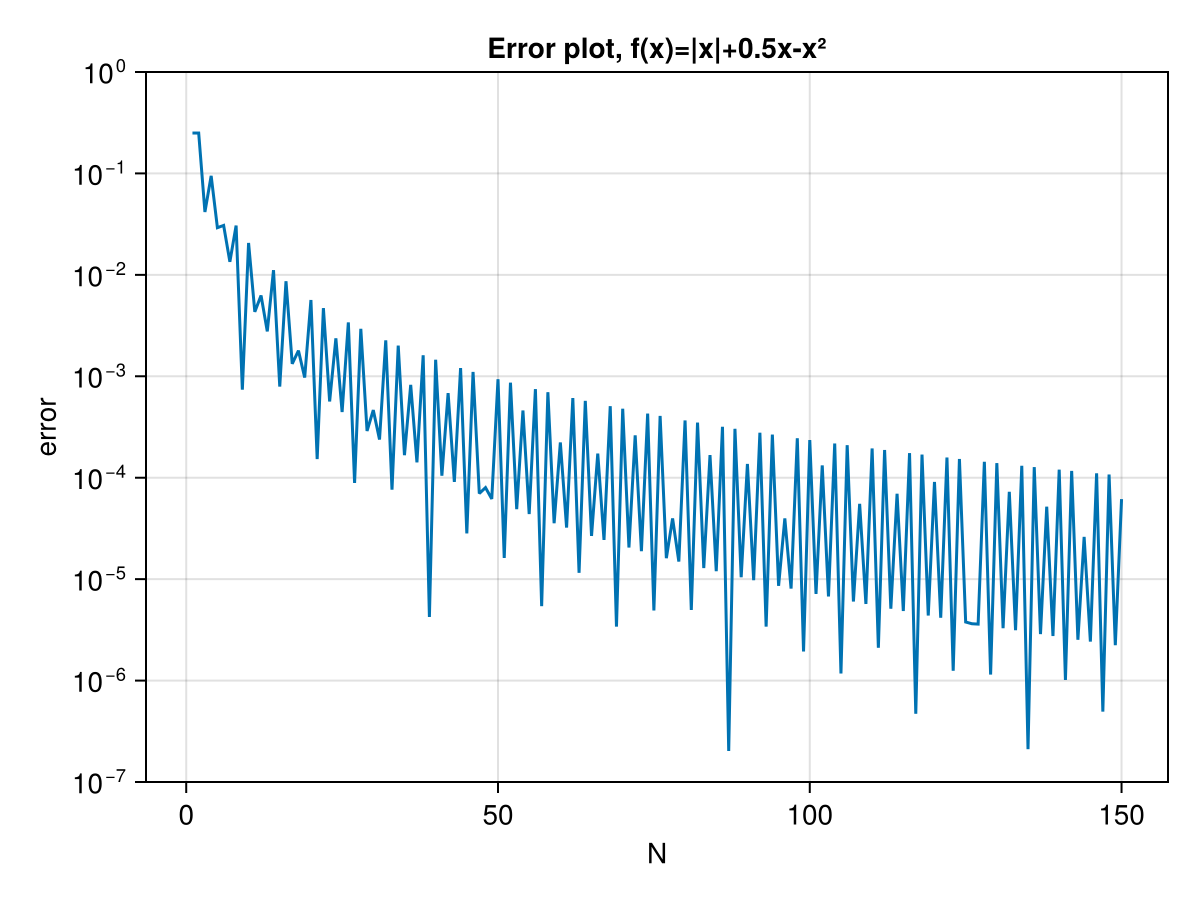

In [114]:
xivals=[0.5,0.75] #points you want to evaluate at
ni=[1:1:150;] #a sequence of increasing n from 1 to 150
max_error2=fill(NaN, length(ni))
true_fxi2=binter_example.(xivals)
for k in 1:length(ni)
    xjvals_ni=cos.(pi*(0:ni[k])'/ni[k])[:] #interpolation points in the form of chebyshev points of the 2nd kind or n=ni[k]
    fvec_ni2=binter_example.(xjvals_ni)[:]#fj values for xj values given n=ni[k]
    emat_ni2=j_eval(xjvals_ni,xivals) #E matrix of lj(xi) components
    fxivals_ni2=(emat_ni2*fvec_ni2)#finds estimated value of f(xi) using interpolation (polynomial)
    max_error2[k]=findmax(abs.(fxivals_ni2-true_fxi2))[1] #finds maximum error between approximated f(xi) and the true f(xi)
end 

fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="N",ylabel="error", title="Error plot, f(x)=|x|+0.5x-x²", yscale=log10) #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
lines!(ax3,ni,max_error2)
ylims!(ax3,[1e-7,1])
fig3

# Stability using barycentric interpolation - Breda et al 2009 method

The stability of an equilibrium point can be found using barycentric interpolation. The function ```stab_func_DDE``` uses barycentric interpolation as a basis to find the stability, whose adjusted method is discussed in (Breda et al 2009). Below is an example for a delay differential equation system that models the interaction between two neurons. A more indepth look at this system can be found in the "Neuron_example" demo (in the "Neuron_demo" folder) but it's system is given by:
```math
\begin{align}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align}
```

In [ ]:
using LinearAlgebra
include("../Neuron_demo/neuronfunc.jl") #system of neuron example
include("../Neuron_demo/neurontau.jl") #Delay forumla for neuron example
include("../shared/f_deriv.jl") #used to find state and/or parameter derivatives
include("../shared/jacobian.jl") #Jacobian function
include("../shared/newton.jl") #Newton function
include("../shared/track_curve.jl") #Tracking curve function (used for continuation and equilibria branches)
include("../shared/create_ststfunc.jl") #Initialisates a function to find equilibria 
include("../shared/create_hopffunc.jl")#finds initial guess for Hopf information and creates a function that can find the true Hopf values
include("../shared/stab_func_DDE.jl")#finds stability and eigenvalues (and if asked, eignevectors) using method found in (Breda et al 2009) and depends on j_eval and j_diff

stab_func_DDE (generic function with 1 method)

In [116]:
#Values of parameters (same as those given in the neuron demo for DDE-Biftool)
k=0.5
beta=-1
a12=1
a21=2.34 
tau1=0.2
tau2=0.2
taus=1.5

nd=3 #there are 3 delays
y0,feq=create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,0,tau1,tau2,taus], nd, par_indx=4) #we set a21 to 0 and finding starting point for equilibria branching
alist1,ytan1=track_curve(feq,y0,[0.0,0,1],nmax=550)#tracks equilibria to give equilibria branch

xmat1=hcat([u[1] for u in alist1],[u[2] for u in alist1]); #finds the values of x1 and x2 for the equilibria
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)];#creates a vector of vectors of all the equilibria points


plist1=[u[3] for u in alist1]; #A vector of the values of a21 for the equilibria points


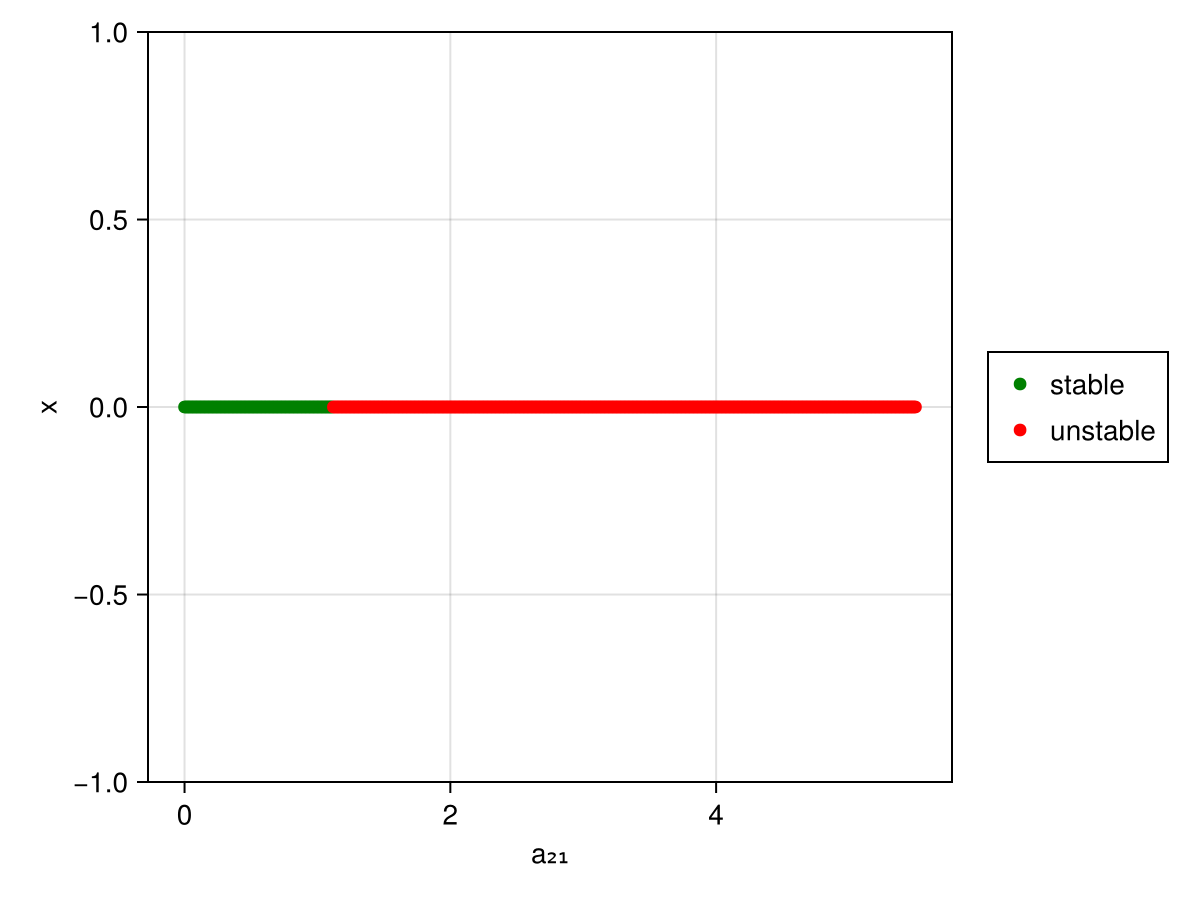

In [121]:
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)
N=50

for i in 1:neq
    A0=f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=1) #finds partial derivative matrix with respect to x(t)
    A1=f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=2) #finds partial derivative matrix with respect to x(t-τ_1)
    A2=f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=3) #finds partial derivative matrix with respect to x(t-τ_2)
    A3=f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=4) #finds partial derivative matrix with respect to x(t-τ_s)
    stab[i],=stab_func_DDE([A0,A1,A2,A3],[tau1,tau2,taus],N) #gives stability of each equilibrium point
end

stable=(stab.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax4,plist1[stable],[u[1] for u in xlist1[stable]],label="stable",color="green")
scatter!(ax4,plist1[unstable],[u[1] for u in xlist1[unstable]],label="unstable",color="red")
Legend(fig4[1,2], ax4, merge=true)
fig4

Hence, with ```stab_func_DDE```'s dependence on `j_eval` and `j_diff`, barycentric interpolation can be used as part of finding stability of delay differential equations. The use of `stab_func_DDE` is explored and explained further in "Stability_finding_for_DDEs" (located in the "DDE_stability_Breda_et_al" folder).

# References

1. J-P. Berrut, L.N. Trefethen, *Barycentric Lagrange Interpolation*, SIAM Review, Vol 46, No.3, pp. 501-517, 2004
2. D. Breda, S. Maset and R. Vermiglio . *TACE-DDE: a Tool for Robust Analysis and Characteristic Equations for Delay Differential Equations*, volume 388, pages 145-155, 2009